# Latincom 2025 - Anomaly Detection in Industrial IoT (IIoT)

Dataset: https://ieee-dataport.org/documents/bruriiot-dataset-network-anomaly-detection-iiot-enhanced-feature-engineering-approach


## 1. Import libraries

In [1]:
import polars as pl
import pandas as pd
import numpy as np
import time
import os
import gc

from pipeline.preprocessing import (
    create_splits, 
    transform_labels, 
    get_labels_mapping,
    balance_labels_with_smote
)
from pipeline.feature_selection import (
    fs_mutual_information,
    fs_markov_blanket,
    fs_boruta,
    fs_rfe,
    random_features
)
from pipeline.model import train_xgboost
from pipeline.training_size import training_size
from pipeline.utils import create_data_dirs, get_protocols, filter_module

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

%matplotlib inline

# create directories
create_data_dirs()

SEED = 20  # 5 seeds: 0, 10, 20, 30 and 40
MODEL_SAVE_DIR_TS = './data/models/training_size'  # training size
MODEL_SAVE_DIR_FS = './data/models/feature_selection'  # feature selection

## 2. Create data splits

Split into training (55%), feature selection (5%), validation (20%) and test (20%)

In [2]:
# load dataset with Polars
df = pl.read_csv('./data/datasets/BRUIIoT.csv')
print('Original dataset size:', df.shape)
print(f'There are {df.shape[0]} total observations.')

# create splits
print('\nSplits division:')
df_train, df_fs, df_valid, df_test = create_splits(df, './data/datasets/splits', seed=SEED)

# clear memory
del df
gc.collect()

Original dataset size: (2776422, 267)
There are 2776422 total observations.

Splits division:
Training division: 0.55
Feature Selection division: 0.05
Validation division: 0.2
Test division: 0.2


0

## 3. Preprocess data

### 3.1 Transform labels

In [3]:
# transform labels to normal, mirai, icmp, syn and others
df_train = transform_labels(df_train)
df_fs = transform_labels(df_fs)
df_valid = transform_labels(df_valid)
df_test = transform_labels(df_test)

In [4]:
# check labels
get_labels_mapping(df_train)

{0: 'normal',
 1: 'Mirai-greeth_flood',
 2: 'ddos_icmp_flood',
 3: 'ddos_syn_flood',
 4: 'other_attack_type'}

### 3.2 Balance training labels

In [5]:
# plotting
df_labels_original = df_train['attack_label__most_frequent'].value_counts().to_pandas()
df_labels_original['type'] = 'Original'
df_labels_original = df_labels_original.sort_values(by='count', ascending=False)
df_labels_original

,attack_label__most_frequent,count,type
4,other_attack_type,699356,Original
2,ddos_syn_flood,556741,Original
3,ddos_icmp_flood,127874,Original
0,Mirai-greeth_flood,89747,Original
1,normal,53315,Original


In [6]:
%%time
start_time = time.perf_counter()

# balance training labels (SMOTE)
df_train = balance_labels_with_smote(df_train, seed=SEED)

end_time = time.perf_counter()
smote_time = end_time - start_time

df_train.shape

Has normal label more than 305406 to cut? False
Has mirai label more than 305406 to cut? False
Has icmp label more than 305406 to cut? False
Has syn label more than 305406 to cut? True
Has others label more than 305406 to cut? True
CPU times: user 6min 5s, sys: 11.2 s, total: 6min 16s
Wall time: 2min 21s


(1527030, 265)

In [7]:
# plotting
df_labels_balanced = pd.DataFrame({
    'attack_label__most_frequent': df_labels_original['attack_label__most_frequent'],
    'count': df_train['attack_label_enc__most_frequent'].value_counts().to_list()
})
df_labels_balanced['type'] = 'Balanced'

df_labels_plot = pd.concat([df_labels_original, df_labels_balanced], axis=0)
df_labels_plot

,attack_label__most_frequent,count,type
4,other_attack_type,699356,Original
2,ddos_syn_flood,556741,Original
3,ddos_icmp_flood,127874,Original
0,Mirai-greeth_flood,89747,Original
1,normal,53315,Original
4,other_attack_type,305406,Balanced
2,ddos_syn_flood,305406,Balanced
3,ddos_icmp_flood,305406,Balanced
0,Mirai-greeth_flood,305406,Balanced
1,normal,305406,Balanced


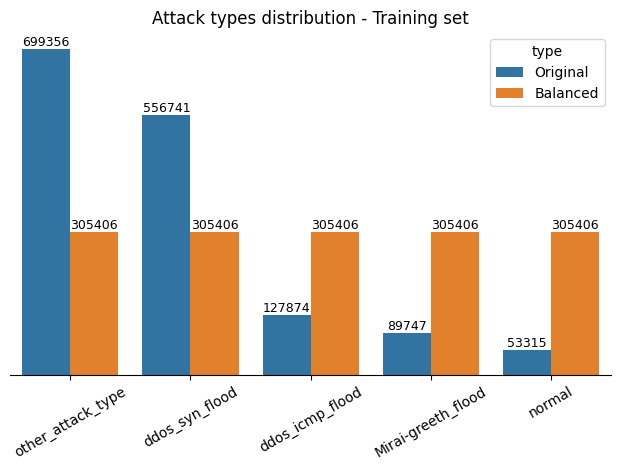

In [19]:
ax = sns.barplot(df_labels_plot, x='attack_label__most_frequent', y='count', hue='type')
ax.bar_label(ax.containers[0], fontsize=9)
ax.bar_label(ax.containers[1], fontsize=9)
ax.tick_params(left=False)
ax.set(yticklabels=[])

sns.despine(top=True, right=True, left=True, bottom=False)
plt.title('Attack types distribution - Training set')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig(f"./data/results/attack_distribution_training.png", bbox_inches='tight')
plt.show()

### 3.3 Save data splits

In [9]:
# save preprocessed splits to disk
df_train.to_csv(f'./data/datasets/splits/BRUIIoT_train_preprocessed_seed{SEED}.csv', index=False)
df_fs.write_csv(f'./data/datasets/splits/BRUIIoT_fs_preprocessed_seed{SEED}.csv')
df_valid.write_csv(f'./data/datasets/splits/BRUIIoT_valid_preprocessed_seed{SEED}.csv')
df_test.write_csv(f'./data/datasets/splits/BRUIIoT_test_preprocessed_seed{SEED}.csv')

In [10]:
del df_train, df_fs, df_valid, df_test
gc.collect()

171

## 4. Determining Sufficient Training set size

In [2]:
# restore preprocessed data splits
df_train = pd.read_csv(f'./data/datasets/splits/BRUIIoT_train_preprocessed_seed{SEED}.csv')
df_valid = pd.read_csv(f'./data/datasets/splits/BRUIIoT_valid_preprocessed_seed{SEED}.csv')

# shuffle training set
df_train = df_train.sample(frac=1, random_state=SEED).reset_index(drop=True)

# label columns
targets_cols = ['attack_label__most_frequent', 'attack_label_enc__most_frequent', 'is_attack__most_frequent']

# labels mapping
labels = get_labels_mapping(df_valid)

In [3]:
# keep only protocol features
df_train = df_train.drop(columns=['frame.time__calculate_duration'])
df_valid = df_valid.drop(columns=['frame.time__calculate_duration'])

# get features and targets from validation
X_valid = df_valid.drop(columns=targets_cols+['index'])
y_valid = df_valid.loc[:, 'attack_label_enc__most_frequent']

print('Training size:', df_train.shape)
print('Validation features size:', X_valid.shape)
print('Validation labels size:', y_valid.shape)

Training size: (1527030, 264)
Validation features size: (555284, 263)
Validation labels size: (555284,)


 95%|███████████████████████████████████████████████▌  | 19/20 [09:48<01:04, 64.67s/it, prop=100.0%, train_size=1527030]

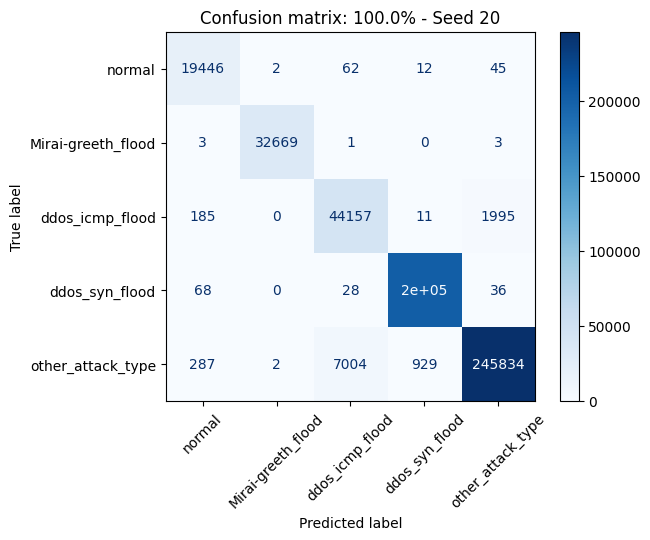

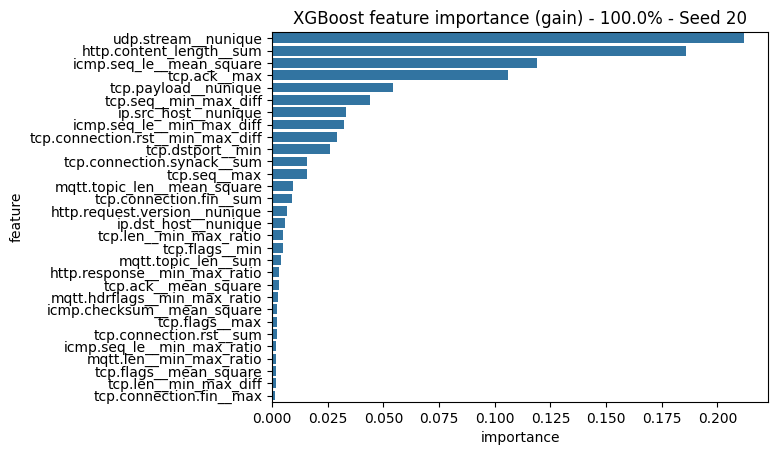

100%|██████████████████████████████████████████████████| 20/20 [11:15<00:00, 33.79s/it, prop=100.0%, train_size=1527030]

Evaluation accuracy: 0.9807792048753431
Evaluation precision: 0.9642427768335736
Evaluation recall: 0.9826629467981866
Evaluation f1-score: 0.9729422763742569


In [4]:
# run training size variation
start_time = time.perf_counter()

df_results = training_size(
    df_train, 
    X_valid, y_valid, 
    seed=SEED,
    model_save_dir=MODEL_SAVE_DIR_TS,
    labels=labels,
)

end_time = time.perf_counter()
training_size_time = end_time - start_time

# save results
df_results.to_csv(f'./data/results/training_size/training_size_results_seed{SEED}.csv', index=False)

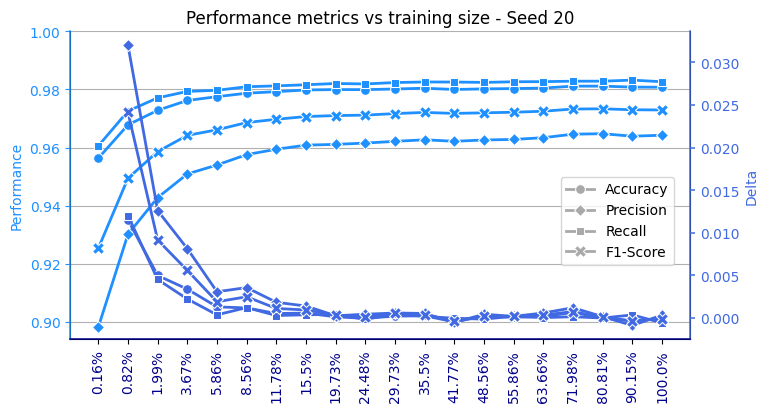

In [8]:
left_color = 'dodgerblue'
right_color = 'royalblue'

plt.figure(figsize=(8, 4))

sns.lineplot(df_results, y='accuracy', x='model', label='Accuracy', linewidth=2, marker='o', markersize=7, color=left_color)
sns.lineplot(df_results, y='precision', x='model', label='Precision', linewidth=2, marker='D', color=left_color)
sns.lineplot(df_results, y='recall', x='model', label='Recall', linewidth=2, marker='s', color=left_color)
ax = sns.lineplot(df_results, y='f1-score', x='model', label='F1-Score', linewidth=2, marker='X', markersize=8, color=left_color)
ax.tick_params(axis='y', colors=left_color)
ax.yaxis.grid(True)

plt.xlabel('')
plt.ylabel('Performance', color=left_color)
plt.xticks(rotation=90, color='darkblue')
plt.ylim(top=1)
# Get the legend object
legend = plt.legend()
handles = legend.legend_handles
for h in handles:
    h.set_color('darkgray')
sns.move_legend(plt.gca(), loc='upper left', bbox_to_anchor=(0.78, 0.55))

ax2 = plt.twinx()

sns.lineplot(y=df_results['accuracy'].diff().values, x=df_results['model'].to_list(), linewidth=2, marker='o', markersize=7, color=right_color, ax=ax2)
sns.lineplot(y=df_results['precision'].diff().values, x=df_results['model'].to_list(), linewidth=2, marker='D', color=right_color, ax=ax2)
sns.lineplot(y=df_results['recall'].diff().values, x=df_results['model'].to_list(), linewidth=2, marker='s', color=right_color, ax=ax2)
ax = sns.lineplot(y=df_results['f1-score'].diff().values, x=df_results['model'].to_list(), linewidth=2, marker='X', markersize=8, color=right_color, ax=ax2)

ax.tick_params(axis='y', colors=right_color)
ax.spines['left'].set_color(left_color)
ax.spines['right'].set_color(right_color)
ax.spines['bottom'].set_color('darkblue')
ax.spines['left'].set_linewidth(1.1)
ax.spines['right'].set_linewidth(1.1)
ax.spines['bottom'].set_linewidth(1.1)
ax.tick_params(width=1.1)

sns.despine(top=True, right=False, left=False, bottom=False)
plt.ylabel('Delta', color=right_color)
plt.title(f'Performance metrics vs training size - Seed {SEED}')
plt.savefig(f"./data/results/training_size/metrics_seed{SEED}.png", bbox_inches='tight')
plt.show()

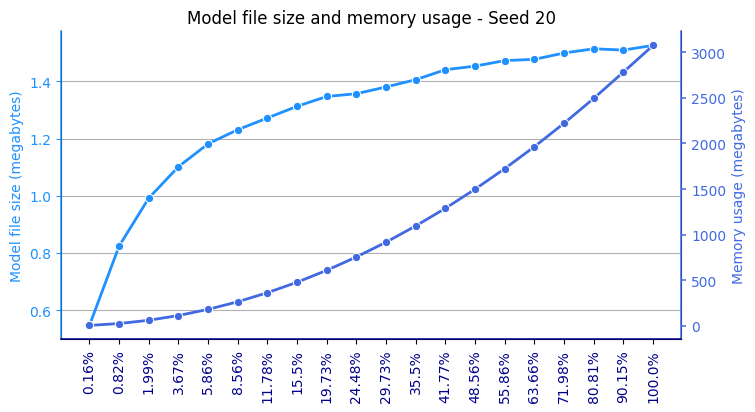

In [7]:
left_color = 'dodgerblue'
right_color = 'royalblue'

plt.figure(figsize=(8, 4))

ax = sns.lineplot(df_results, y='model_size', x='model', linewidth=2, marker='o', color=left_color)
ax.tick_params(axis='y', colors=left_color)
ax.yaxis.grid(True)

plt.xticks(rotation=90, color='darkblue')
plt.xlabel('')
plt.ylabel('Model file size (megabytes)', color=left_color)

ax2 = plt.twinx()

ax = sns.lineplot(df_results, y='memory_usage', x='model', linewidth=2, marker='o', color=right_color, ax=ax2)
ax.tick_params(axis='y', colors=right_color)
ax.spines['left'].set_color(left_color)
ax.spines['right'].set_color(right_color)
ax.spines['bottom'].set_color('darkblue')
ax.spines['left'].set_linewidth(1.1)
ax.spines['right'].set_linewidth(1.1)
ax.spines['bottom'].set_linewidth(1.1)
ax.tick_params(width=1.1)

sns.despine(top=True, right=False, left=False, bottom=False)
plt.ylabel('Memory usage (megabytes)', color=right_color)
plt.title(f'Model file size and memory usage - Seed {SEED}')
plt.savefig(f"./data/results/training_size/filesize-memory_seed{SEED}.png", bbox_inches='tight')
plt.show()

In [16]:
# training proportion to sample
training_size_prop = 0.155

# sufficient training set size
df_train = df_train.sample(frac=training_size_prop, random_state=SEED)
print('Defined training size:', df_train.shape[0])

# save training set with all features
df_train.to_csv(f'./data/datasets/splits/BRUIIoT_train_size{training_size_prop}_seed{SEED}.csv', index=False)

Defined training size: 236690


## 5. Feature selection

In [17]:
# restore remaining data splits (fs and test)
df_fs = pd.read_csv(f'./data/datasets/splits/BRUIIoT_fs_preprocessed_seed{SEED}.csv')
df_test = pd.read_csv(f'./data/datasets/splits/BRUIIoT_test_preprocessed_seed{SEED}.csv')

# get procotols
modules = get_protocols(df_fs, targets_cols)

In [18]:
# keep only protocols
df_fs = df_fs.drop(columns=['frame.time__calculate_duration'])
df_test = df_test.drop(columns=['frame.time__calculate_duration'])

# get features and targets
X_train = df_train.drop(columns=['attack_label_enc__most_frequent'])
X_fs = df_fs.drop(columns=targets_cols+['index'])
X_valid = df_valid.drop(columns=targets_cols+['index'])
X_test = df_test.drop(columns=targets_cols+['index'])

y_train = df_train.loc[:, 'attack_label_enc__most_frequent']
y_fs = df_fs.loc[:, 'attack_label_enc__most_frequent']
y_valid = df_valid.loc[:, 'attack_label_enc__most_frequent']
y_test = df_test.loc[:, 'attack_label_enc__most_frequent']

print('Training features size:', X_train.shape)
print('FS features size:', X_fs.shape)
print('Validation features size:', X_valid.shape)
print('Test features size:', X_test.shape)
print('')
print('Training labels size:', y_train.shape)
print('FS labels size:', y_fs.shape)
print('Validation labels size:', y_valid.shape)
print('Test labels size:', y_test.shape)

Training features size: (236690, 263)
FS features size: (138821, 263)
Validation features size: (555284, 263)
Test features size: (555284, 263)

Training labels size: (236690,)
FS labels size: (138821,)
Validation labels size: (555284,)
Test labels size: (555284,)


In [19]:
for m in modules:
    print(f'**Processing module {m}...**')

    # get module's columns
    cols = filter_module(df_train.columns, m)
    print(f'Columns length: {len(cols)}, columns:', cols)
    print('')

**Processing module udp...**
Columns length: 11, columns: ['udp.port__nunique', 'udp.stream__nunique', 'udp.time_delta__min', 'udp.time_delta__max', 'udp.time_delta__sum', 'udp.time_delta__mean', 'udp.time_delta__calculate_duration', 'udp.time_delta__min_max_diff', 'udp.time_delta__min_max_ratio', 'udp.time_delta__min_max_product', 'udp.time_delta__mean_square']

**Processing module mqtt...**
Columns length: 54, columns: ['mqtt.conflag.cleansess__min', 'mqtt.conflag.cleansess__max', 'mqtt.conflag.cleansess__sum', 'mqtt.conflag.cleansess__mean', 'mqtt.conflag.cleansess__min_max_diff', 'mqtt.conflag.cleansess__min_max_ratio', 'mqtt.conflag.cleansess__min_max_product', 'mqtt.conflag.cleansess__mean_square', 'mqtt.conflags__min', 'mqtt.conflags__max', 'mqtt.conflags__sum', 'mqtt.conflags__mean', 'mqtt.conflags__nunique', 'mqtt.conflags__min_max_diff', 'mqtt.conflags__min_max_ratio', 'mqtt.conflags__min_max_product', 'mqtt.conflags__mean_square', 'mqtt.hdrflags__min', 'mqtt.hdrflags__max', 

### 5.1 Mutual Information (MI)

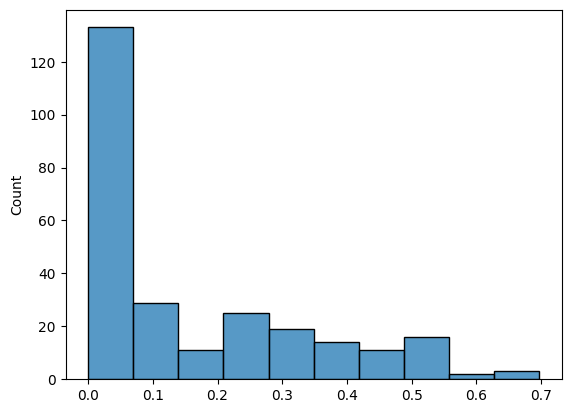

CPU times: user 1.52 s, sys: 541 ms, total: 2.06 s
Wall time: 23.5 s


(66,
 Index(['ip.src_host__nunique', 'ip.dst_host__nunique',
        'icmp.checksum__min_max_diff', 'icmp.checksum__min_max_ratio',
        'icmp.seq_le__min', 'icmp.seq_le__max', 'icmp.seq_le__sum',
        'icmp.seq_le__mean', 'icmp.seq_le__min_max_diff',
        'icmp.seq_le__min_max_ratio', 'icmp.seq_le__min_max_product',
        'icmp.seq_le__mean_square', 'tcp.ack__min', 'tcp.ack__max',
        'tcp.ack__sum', 'tcp.ack__mean', 'tcp.ack__min_max_diff',
        'tcp.ack__min_max_ratio', 'tcp.ack__min_max_product',
        'tcp.ack__mean_square', 'tcp.ack_raw__min', 'tcp.ack_raw__max',
        'tcp.ack_raw__sum', 'tcp.ack_raw__mean', 'tcp.ack_raw__min_max_diff',
        'tcp.ack_raw__min_max_ratio', 'tcp.ack_raw__min_max_product',
        'tcp.ack_raw__mean_square', 'tcp.checksum__min_max_diff',
        'tcp.checksum__min_max_ratio', 'tcp.connection.syn__sum',
        'tcp.connection.syn__mean', 'tcp.connection.syn__mean_square',
        'tcp.connection.synack__sum', 'tcp.connection

In [20]:
%%time
start_time = time.perf_counter()

mi_features = fs_mutual_information(X_fs, y_fs, seed=SEED)

end_time = time.perf_counter()
mi_decision_time = end_time - start_time

len(mi_features), mi_features

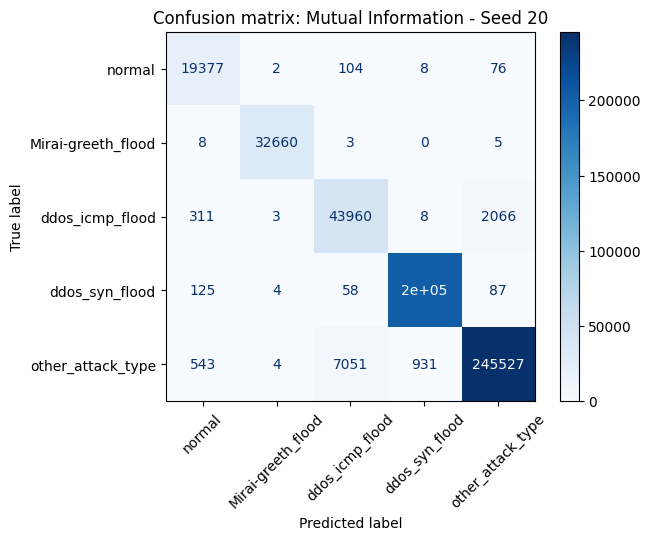

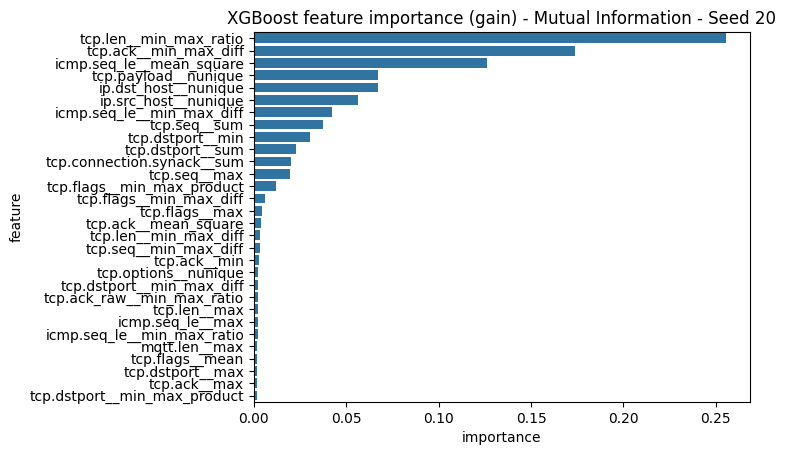

Evaluation accuracy: 0.9794753675596631
Evaluation precision: 0.9592911944812824
Evaluation recall: 0.9806706697074945
Evaluation f1-score: 0.9694292440365524


,model,accuracy,precision,recall,f1-score
0,Mutual Information,0.979475,0.959291,0.980671,0.969429


In [21]:
start_time = time.perf_counter()

mi_results = train_xgboost(
    X_train.loc[:, mi_features], y_train, 
    X_valid.loc[:, mi_features], y_valid, 
    seed=SEED,
    method_name='Mutual Information', 
    save_dir=MODEL_SAVE_DIR_FS,
    filename=f'mi_seed{SEED}.pkl',
    labels=labels
)

end_time = time.perf_counter()
mi_training_time = end_time - start_time

mi_results

### 5.2 Markov Blanket

  0%|          | 0/9 [00:00<?, ?it/s]

Intermediate number of selected features: 48
Running final selection...


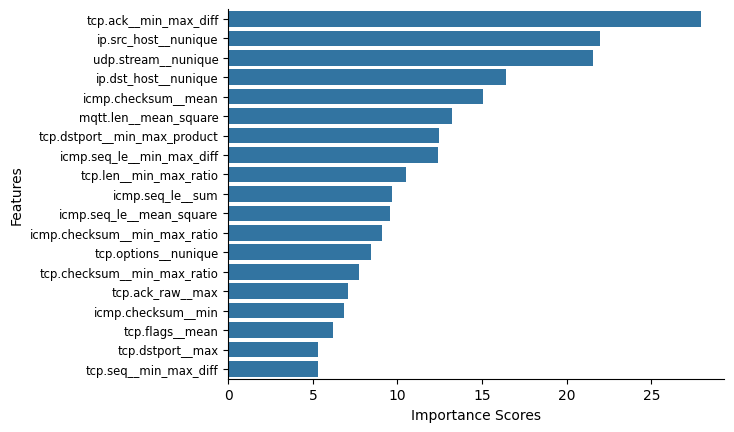

CPU times: user 1.78 s, sys: 303 ms, total: 2.08 s
Wall time: 5min 35s


(19,
 Index(['tcp.ack__min_max_diff', 'ip.src_host__nunique', 'udp.stream__nunique',
        'ip.dst_host__nunique', 'icmp.checksum__mean', 'mqtt.len__mean_square',
        'tcp.dstport__min_max_product', 'icmp.seq_le__min_max_diff',
        'tcp.len__min_max_ratio', 'icmp.seq_le__sum',
        'icmp.seq_le__mean_square', 'icmp.checksum__min_max_ratio',
        'tcp.options__nunique', 'tcp.checksum__min_max_ratio',
        'tcp.ack_raw__max', 'icmp.checksum__min', 'tcp.flags__mean',
        'tcp.dstport__max', 'tcp.seq__min_max_diff'],
       dtype='object'))

In [22]:
%%time
start_time = time.perf_counter()

causal_selected_features = fs_markov_blanket(X_fs, y_fs, modules, seed=SEED, thresholds=[0.001, 0.01], val_size=0.1)

end_time = time.perf_counter()
mb_decision_time = end_time - start_time

len(causal_selected_features), causal_selected_features

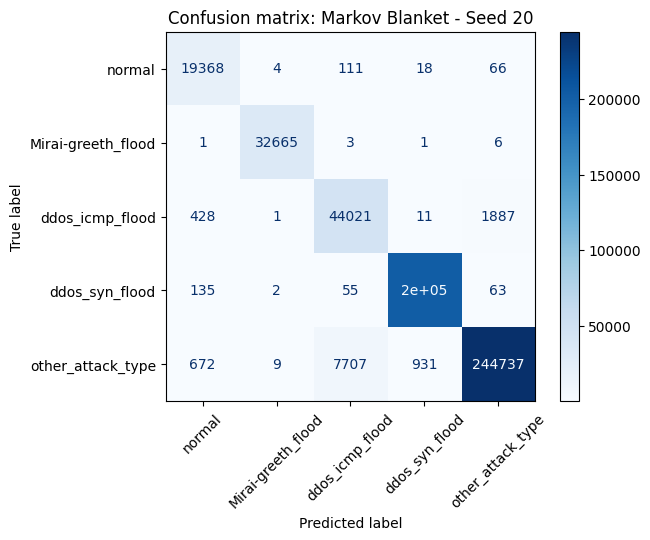

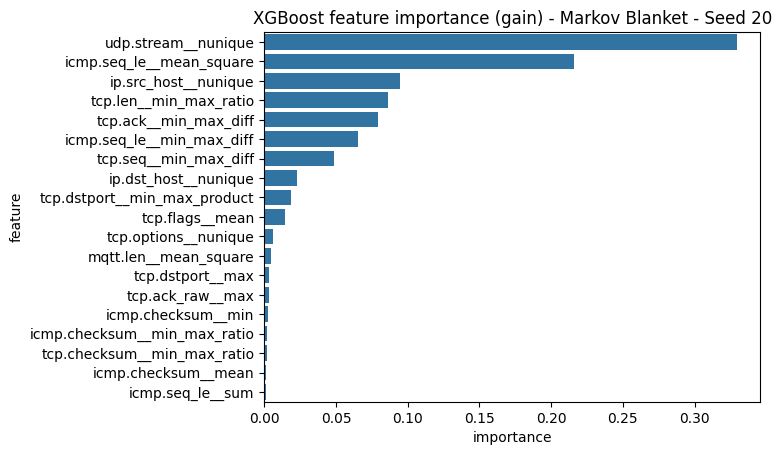

Evaluation accuracy: 0.978189539046686
Evaluation precision: 0.9549679376094498
Evaluation recall: 0.9802693502341706
Evaluation f1-score: 0.9668743347622055


,model,accuracy,precision,recall,f1-score
0,Markov Blanket,0.97819,0.954968,0.980269,0.966874


In [23]:
start_time = time.perf_counter()

mb_results = train_xgboost(
    X_train.loc[:, causal_selected_features], y_train, 
    X_valid.loc[:, causal_selected_features], y_valid, 
    seed=SEED,
    method_name='Markov Blanket', 
    save_dir=MODEL_SAVE_DIR_FS,
    filename=f'mb_seed{SEED}.pkl',
    labels=labels
)

end_time = time.perf_counter()
mb_training_time = end_time - start_time

mb_results

### 5.3 Boruta

In [24]:
%%time
start_time = time.perf_counter()

boruta_selected_features = fs_boruta(X_fs, y_fs, seed=SEED, max_iter=30, n_estimators=100)

end_time = time.perf_counter()
boruta_decision_time = end_time - start_time

print(len(boruta_selected_features))
boruta_selected_features.to_list()

Iteration: 	1 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	2 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	3 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	4 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	5 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	6 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	7 / 30
Confirmed: 	0
Tentative: 	263
Rejected: 	0
Iteration: 	8 / 30
Confirmed: 	97
Tentative: 	45
Rejected: 	121
Iteration: 	9 / 30
Confirmed: 	97
Tentative: 	45
Rejected: 	121
Iteration: 	10 / 30
Confirmed: 	97
Tentative: 	45
Rejected: 	121
Iteration: 	11 / 30
Confirmed: 	97
Tentative: 	45
Rejected: 	121
Iteration: 	12 / 30
Confirmed: 	103
Tentative: 	39
Rejected: 	121
Iteration: 	13 / 30
Confirmed: 	103
Tentative: 	39
Rejected: 	121
Iteration: 	14 / 30
Confirmed: 	103
Tentative: 	39
Rejected: 	121
Iteration: 	15 / 30
Confirmed: 	103
Tentative: 	39
Rejected: 	121
Iteration: 	16 / 30
Confirmed: 	105
Tentativ

['ip.src_host__nunique',
 'ip.dst_host__nunique',
 'icmp.checksum__min',
 'icmp.checksum__max',
 'icmp.checksum__sum',
 'icmp.checksum__mean',
 'icmp.checksum__min_max_diff',
 'icmp.checksum__min_max_ratio',
 'icmp.checksum__min_max_product',
 'icmp.checksum__mean_square',
 'icmp.seq_le__min',
 'icmp.seq_le__max',
 'icmp.seq_le__sum',
 'icmp.seq_le__mean',
 'icmp.seq_le__min_max_diff',
 'icmp.seq_le__min_max_ratio',
 'icmp.seq_le__min_max_product',
 'icmp.seq_le__mean_square',
 'http.file_data__nunique',
 'http.content_length__max',
 'http.content_length__sum',
 'http.content_length__mean',
 'http.content_length__min_max_diff',
 'http.content_length__min_max_ratio',
 'http.content_length__mean_square',
 'http.request.method__nunique',
 'http.request.version__nunique',
 'http.response__sum',
 'tcp.ack__min',
 'tcp.ack__max',
 'tcp.ack__sum',
 'tcp.ack__mean',
 'tcp.ack__min_max_diff',
 'tcp.ack__min_max_ratio',
 'tcp.ack__min_max_product',
 'tcp.ack__mean_square',
 'tcp.ack_raw__min',
 

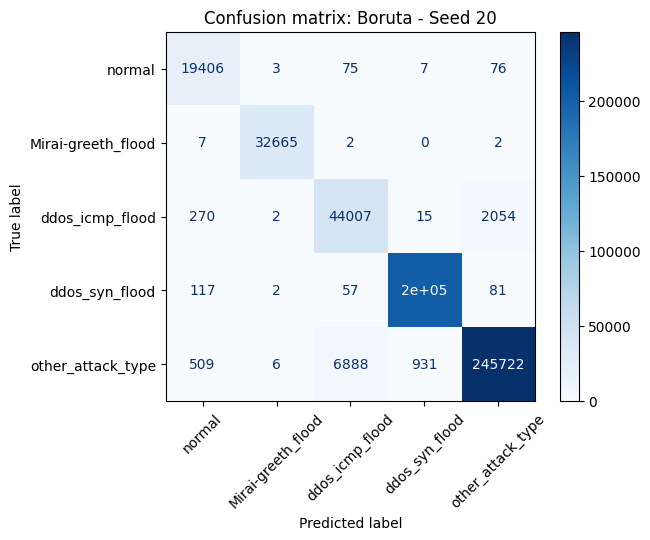

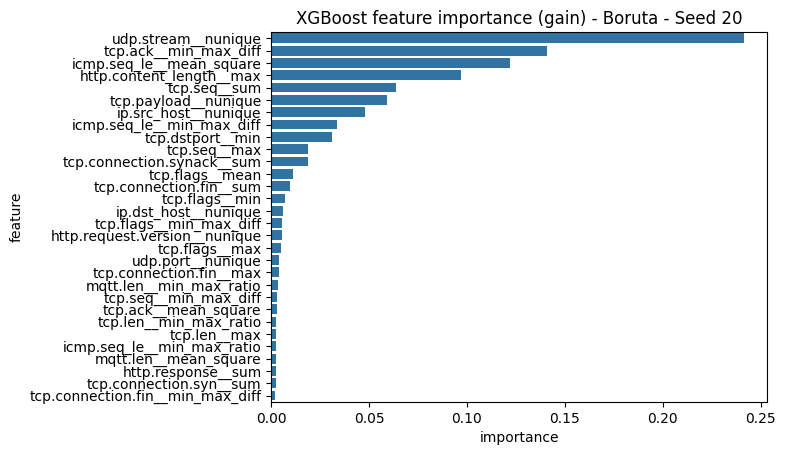

Evaluation accuracy: 0.9800030254788541
Evaluation precision: 0.9607836973314349
Evaluation recall: 0.9813707923783163
Evaluation f1-score: 0.9705614262802232


,model,accuracy,precision,recall,f1-score
0,Boruta,0.980003,0.960784,0.981371,0.970561


In [25]:
start_time = time.perf_counter()

boruta_results = train_xgboost(
    X_train.loc[:, boruta_selected_features], y_train, 
    X_valid.loc[:, boruta_selected_features], y_valid, 
    seed=SEED,
    method_name='Boruta', 
    save_dir=MODEL_SAVE_DIR_FS,
    filename=f'boruta_seed{SEED}.pkl',
    labels=labels
)

end_time = time.perf_counter()
boruta_training_time = end_time - start_time

boruta_results

### 5.4 Recursive Feature Elimination (RFE)

In [26]:
%%time
start_time = time.perf_counter()

rfe_selected_features = fs_rfe(X_fs, y_fs, n_features_to_select=len(causal_selected_features), seed=SEED)

end_time = time.perf_counter()
rfe_decision_time = end_time - start_time

len(rfe_selected_features), rfe_selected_features

CPU times: user 11min 26s, sys: 2.14 s, total: 11min 29s
Wall time: 11min 28s


(19,
 Index(['ip.dst_host__nunique', 'icmp.checksum__max',
        'icmp.checksum__min_max_product', 'icmp.checksum__mean_square',
        'icmp.seq_le__min_max_diff', 'icmp.seq_le__min_max_ratio',
        'tcp.ack__max', 'tcp.ack__mean_square', 'tcp.ack_raw__max',
        'tcp.ack_raw__min_max_ratio', 'tcp.checksum__min_max_diff',
        'tcp.dstport__max', 'tcp.dstport__min_max_ratio',
        'tcp.dstport__min_max_product', 'tcp.dstport__mean_square',
        'tcp.len__max', 'tcp.options__nunique', 'udp.stream__nunique',
        'mqtt.len__min_max_ratio'],
       dtype='object'))

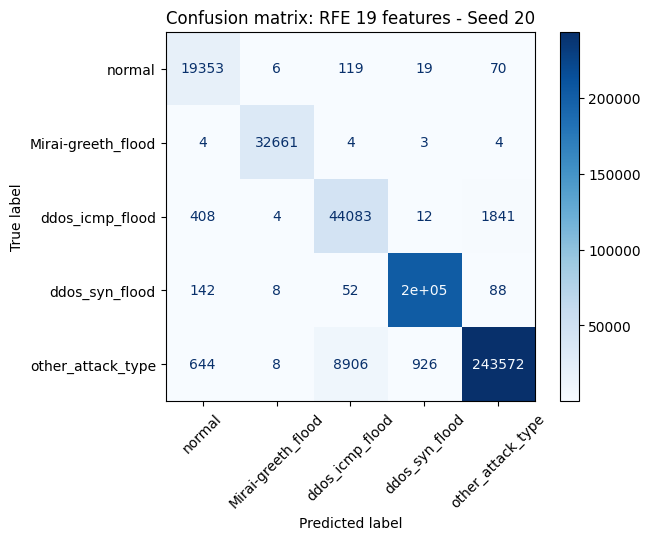

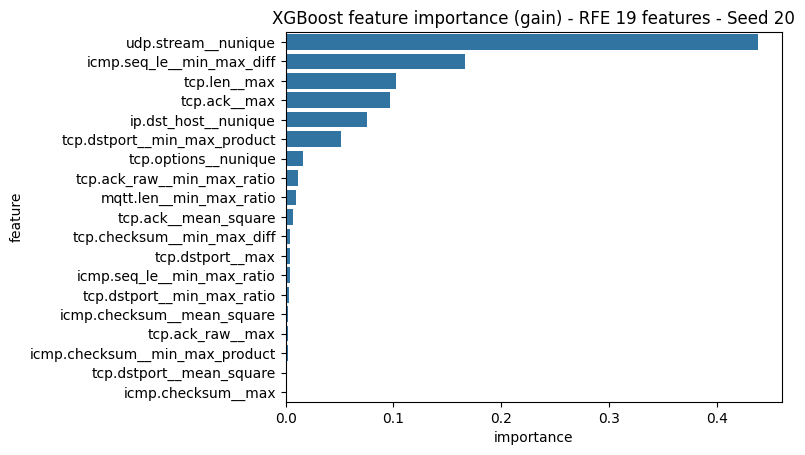

Evaluation accuracy: 0.9761059205739766
Evaluation precision: 0.9514442421151728
Evaluation recall: 0.9794074241138914
Evaluation f1-score: 0.9644176951203475


,model,accuracy,precision,recall,f1-score
0,RFE 19 features,0.976106,0.951444,0.979407,0.964418


In [27]:
start_time = time.perf_counter()

rfe_results = train_xgboost(
    X_train.loc[:, rfe_selected_features], y_train, 
    X_valid.loc[:, rfe_selected_features], y_valid, 
    seed=SEED,
    method_name=f'RFE {len(rfe_selected_features)} features', 
    save_dir=MODEL_SAVE_DIR_FS,
    filename=f'rfe_seed{SEED}.pkl',
    labels=labels
)

end_time = time.perf_counter()
rfe_training_time = end_time - start_time

rfe_results

### 5.5 Random Features

In [28]:
%%time
df_results_random = random_features(
    X_train, y_train, 
    X_valid, y_valid, 
    n_features_to_select=len(causal_selected_features), 
    model_save_dir=MODEL_SAVE_DIR_FS,
    seed=SEED,
)

	Round: 0 Selected features: Index(['tcp.flags.ack__min', 'dns.retransmit_request__mean_square',
       'mqtt.len__min_max_diff', 'arp.opcode__min_max_ratio', 'tcp.seq__mean',
       'dns.qry.name.len__nunique', 'http.response__min_max_product',
       'mqtt.protoname__nunique', 'tcp.flags__min_max_ratio',
       'tcp.srcport__nunique', 'dns.retransmit_request__mean',
       'tcp.seq__mean_square', 'mqtt.msg__nunique', 'http.content_length__min',
       'dns.retransmit_request_in__min_max_product',
       'tcp.ack__min_max_product', 'tcp.ack__sum',
       'tcp.connection.synack__min_max_ratio', 'tcp.flags__mean'],
      dtype='object') - Seed 20
	Round: 1 Selected features: Index(['udp.time_delta__min_max_diff', 'dns.qry.qu__min',
       'tcp.dstport__mean_square', 'http.content_length__max',
       'tcp.ack_raw__min_max_diff', 'tcp.seq__min_max_ratio',
       'udp.time_delta__mean', 'tcp.ack__mean_square',
       'http.request.full_uri__nunique', 'tcp.srcport__nunique',
       'tcp.co

	Round: 13 Selected features: Index(['icmp.seq_le__min', 'mqtt.conflags__min',
       'mqtt.conflag.cleansess__mean_square', 'tcp.dstport__min',
       'tcp.connection.fin__min_max_diff', 'tcp.options__nunique',
       'tcp.seq__min_max_ratio', 'dns.retransmit_request_in__max',
       'tcp.dstport__mean', 'tcp.checksum__min', 'dns.qry.qu__min_max_ratio',
       'mqtt.topic_len__mean', 'dns.retransmission__sum',
       'mqtt.conflags__min_max_product', 'tcp.ack_raw__min_max_product',
       'arp.opcode__min', 'mqtt.conflags__sum',
       'tcp.connection.fin__mean_square', 'tcp.flags.ack__sum'],
      dtype='object') - Seed 20
	Round: 14 Selected features: Index(['tcp.connection.synack__min_max_product', 'dns.retransmission__sum',
       'dns.qry.qu__min', 'dns.retransmit_request__min',
       'tcp.connection.synack__mean', 'mqtt.topic_len__mean_square',
       'tcp.dstport__sum', 'tcp.checksum__min_max_product',
       'mqtt.conflags__sum', 'arp.opcode__mean',
       'http.response__min

	Round: 26 Selected features: Index(['arp.opcode__min_max_diff', 'mqtt.conflags__sum', 'tcp.ack_raw__sum',
       'tcp.connection.syn__min_max_ratio', 'tcp.flags__min_max_ratio',
       'tcp.dstport__min', 'mqtt.msgtype__nunique', 'tcp.connection.fin__mean',
       'tcp.checksum__min', 'dns.retransmission__min_max_product',
       'tcp.ack_raw__min_max_product', 'dns.qry.name.len__nunique',
       'http.response__min_max_diff', 'dns.qry.qu__mean',
       'tcp.connection.syn__min_max_diff', 'mqtt.len__mean',
       'udp.time_delta__mean', 'mqtt.proto_len__max', 'udp.time_delta__sum'],
      dtype='object') - Seed 20
	Round: 27 Selected features: Index(['tcp.connection.rst__mean', 'arp.hw.size__min_max_diff',
       'ip.src_host__nunique', 'dns.retransmission__max',
       'tcp.connection.synack__mean_square', 'tcp.len__mean_square',
       'arp.src.proto_ipv4__nunique', 'http.response__min_max_product',
       'mqtt.topic_len__sum', 'mqtt.conflag.cleansess__min_max_ratio',
       'udp.t

In [29]:
df_results_random.drop(columns=['model']).describe().reset_index()

,index,accuracy,precision,recall,f1-score
0,count,30.000000,30.000000,30.000000,30.000000
1,mean,0.770787,0.787516,0.815729,0.743409
2,std,0.165256,0.084199,0.133094,0.162375
3,min,0.396999,0.632833,0.546675,0.429960
4,25%,0.614519,0.728451,0.668526,0.568178
5,50%,0.828303,0.778049,0.863151,0.798783
6,75%,0.913153,0.844122,0.933242,0.877321
7,max,0.975947,0.947467,0.967509,0.954915


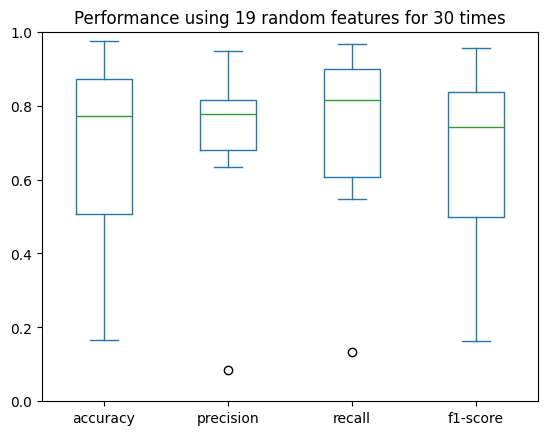

In [30]:
df_results_random.drop(columns=['model']).describe().iloc[1:].plot.box()
plt.title(f'Performance using {len(causal_selected_features)} random features for 30 times')
plt.ylim((0, 1))
plt.show()

### 5.6 Compile results

In [31]:
# number of features
df_num_feats = pd.DataFrame({
    'Mutual Information': [len(mi_features)],
    'Markov Blanket': [len(causal_selected_features)],
    'Boruta': [len(boruta_selected_features)],
    'RFE': [len(rfe_selected_features)],
    'Random Features': [len(causal_selected_features)]
})

df_num_feats.to_csv(f'./data/results/feature_selection/features/number_features_seed{SEED}.csv', index=False)

In [32]:
# features
df_feats = pd.DataFrame({
    'Mutual Information': [list(mi_features)],
    'Markov Blanket': [list(causal_selected_features)],
    'Boruta': [list(boruta_selected_features)],
    'RFE': [list(rfe_selected_features)]
})

df_feats.to_csv(f'./data/results/feature_selection/features/selected_features_seed{SEED}.csv', index=False)

In [33]:
# performance metrics
df_metrics = pd.concat([
    mi_results,
    mb_results,
    boruta_results,
    rfe_results
])
df_metrics.to_csv(f'./data/results/feature_selection/metrics/feature_selection_metrics_seed{SEED}.csv', index=False)

In [34]:
# random features
df_results_random.drop(columns=['model']) \
    .describe() \
    .reset_index() \
    .to_csv(f'./data/results/feature_selection/metrics/random_features_metrics_seed{SEED}.csv', index=False)

In [35]:
# total pipeline time
df_pipeline_time = pd.DataFrame({
    'Type': ['Preprocessing', 'Training size', 'Feature Selection Decision', 'Model Training & Eval'],
    'Mutual Information': [smote_time, training_size_time, mi_decision_time, mi_training_time],
    'Markov Blanket': [smote_time, training_size_time, mb_decision_time, mb_training_time],
    'Boruta': [smote_time, training_size_time, boruta_decision_time, boruta_training_time],
    'RFE': [smote_time, training_size_time, rfe_decision_time, rfe_training_time],
})

df_pipeline_time.to_csv(f'./data/results/feature_selection/pipeline/pipeline_times_seed{SEED}.csv', index=False)